In [1]:
"""
@author: anahí
pip install seaborn
https://scikit-learn.org/stable/modules/tree.html#
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
"""
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')


In [17]:
#%%  CARGAMOS DATASET Y LO CONOCEMOS UN POCO
titanic = sns.load_dataset("titanic")

print(titanic.shape)
print(titanic.columns)
titanic.head()


(891, 15)
Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')


survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True

In [3]:
titanic.describe()

survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [4]:
print(f'Hay datos ausentes? {titanic.isnull().any().any()}')
titanic.info()

Hay datos ausentes? True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


survived
0    549
1    342
dtype: int64


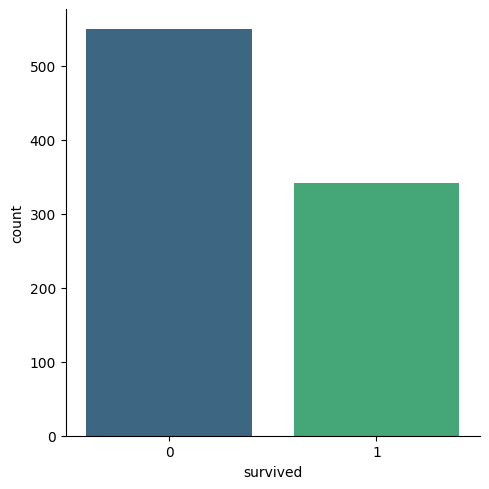

In [8]:
print(titanic.groupby('survived').size())
sns.catplot(x='survived', data = titanic, kind = "count", palette='viridis')
# 1.5 no, 1 si - » hay desbalance

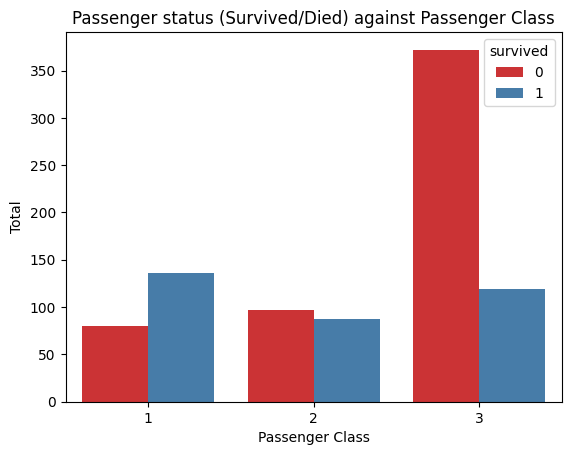

In [9]:
# https://www.kaggle.com/code/thulani96/titanic-dataset-analysis-with-seaborn

ax = sns.countplot(x = 'pclass', hue = 'survived', palette = 'Set1', data = titanic)
ax.set(title = 'Passenger status (Survived/Died) against Passenger Class',
       xlabel = 'Passenger Class', ylabel = 'Total')
plt.show()

survived    0    1
sex               
female     81  233
male      468  109


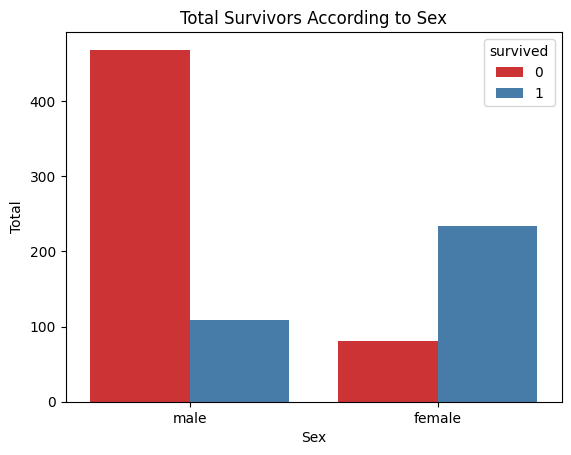

In [10]:
print(pd.crosstab(titanic["sex"],titanic.survived))
ax = sns.countplot(x = 'sex', hue = 'survived', palette = 'Set1', data = titanic)
ax.set(title = 'Total Survivors According to Sex', xlabel = 'Sex', ylabel='Total')
plt.show()

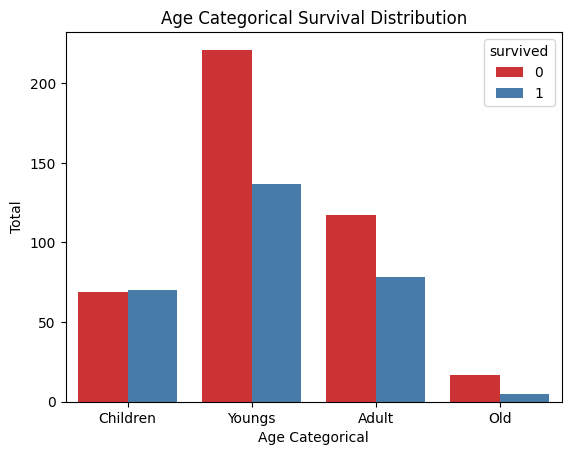

In [11]:
# We look at Age column and set Intevals on the ages and the map them to their categories as
# (Children, Teen, Adult, Old)
interval = (0,18,35,60,120)
categories = ['Children','Youngs','Adult', 'Old']
titanic['age_cats'] = pd.cut(titanic.age, interval, labels = categories)

ax = sns.countplot(x = 'age_cats',  data = titanic, hue = 'survived', palette = 'Set1')

ax.set(xlabel='Age Categorical', ylabel='Total',
       title="Age Categorical Survival Distribution")

plt.show()


survived    0    1
embarked          
C          75   93
Q          47   30
S         427  217


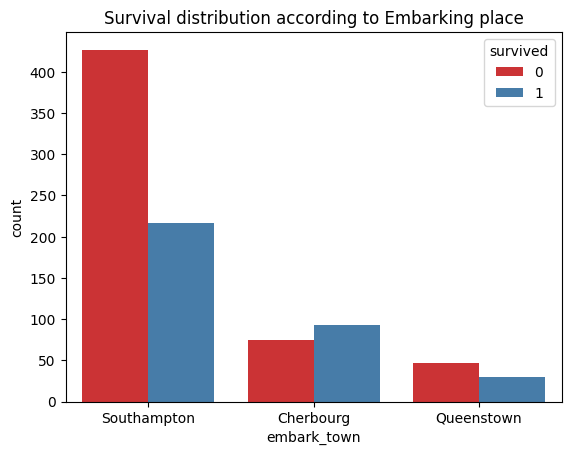

In [12]:
print(pd.crosstab(titanic['embarked'], titanic.survived))
ax = sns.countplot(x = 'embark_town', hue = 'survived', palette = 'Set1', data = titanic)
ax.set(title = 'Survival distribution according to Embarking place')
plt.show()

In [18]:
#%%  PREPARAMOS LOS DATOS PARA EL MODELO
# asignamos el valor medio a los faltantes de la columna 'age'
titanic['age'] = titanic['age'].fillna(titanic.groupby(['pclass', 'sex'])['age'].transform('mean'))
titanic.info()

# quedaron casi todas las columnas sin NaN, excepto 'deck' que sólo tiene 203 valores no nulos
# esa columna la eliminaremos pues no tiene suficientes datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [19]:
# definimos la variable a predecir
y = titanic.pop("survived")

# elegimos las características predictoras
features = ["sex", "class", 'age', 'embark_town', 'adult_male', 'fare', 'sibsp', 'parch', 'alone']    # columnas para usar
X_not = titanic[features]
X_not.head()


      sex  class   age  embark_town  adult_male     fare  sibsp  parch  alone
0    male  Third  22.0  Southampton        True   7.2500      1      0  False
1  female  First  38.0    Cherbourg       False  71.2833      1      0  False
2  female  Third  26.0  Southampton       False   7.9250      0      0   True
3  female  First  35.0  Southampton       False  53.1000      1      0  False
4    male  Third  35.0  Southampton        True   8.0500      0      0   True


In [21]:
X_not.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          891 non-null    object  
 1   class        891 non-null    category
 2   age          891 non-null    float64 
 3   embark_town  889 non-null    object  
 4   adult_male   891 non-null    bool    
 5   fare         891 non-null    float64 
 6   sibsp        891 non-null    int64   
 7   parch        891 non-null    int64   
 8   alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(2), object(2)
memory usage: 44.6+ KB


In [23]:
# aplicamos el método de Pandas equivalente a OneHotEncoder sobre pclass,
# recordar que sólo opera sobre columnas con type= 'object' o 'category'
# pandas.get_dummies(data, prefix=None, prefix_sep=’_’, dummy_na=False,
#                    columns=None, sparse=False, drop_first=False, dtype=None)
X=pd.get_dummies(X_not, prefix_sep='-', dummy_na=False, columns=['sex', 'class', 'embark_town'], drop_first=True)

X

age  adult_male     fare  sibsp  parch  alone  sex-male  class-Second  \
0    22.00        True   7.2500      1      0  False      True         False   
1    38.00       False  71.2833      1      0  False     False         False   
2    26.00       False   7.9250      0      0   True     False         False   
3    35.00       False  53.1000      1      0  False     False         False   
4    35.00        True   8.0500      0      0   True      True         False   
..     ...         ...      ...    ...    ...    ...       ...           ...   
886  27.00        True  13.0000      0      0   True      True          True   
887  19.00       False  30.0000      0      0   True     False         False   
888  21.75       False  23.4500      1      2  False     False         False   
889  26.00        True  30.0000      0      0   True      True         False   
890  32.00        True   7.7500      0      0   True      True         False   

     class-Third  embark_town-Queenstown  embark_town-Southampton  
0           True                   False                     True  
1          False                   False                    False  
2           True                   False                     True  
3          False                   False                     True  
4           True                   False                     True  
..           ...                     ...                      ...  
886        False                   False                     True  
887        False                   False                     True  
888         True                   False                     True  
889        False                   False                    False  
890         True                    True                    False  

[891 rows x 11 columns]

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(),linewidths=0.1, square=True,  linecolor='white', annot=True, cmap='Spectral')
plt.show()
plt.close()

In [24]:
# SEPARAMOS DATASET EN CJTO ENTRENAMIENTO Y TEST 75/25,

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 16, stratify=y)

criterio='entropy'
# criterio='gini'
arbol=DecisionTreeClassifier(criterion=criterio, random_state = 16)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=16)

In [25]:
# instanciamos un bosque aleatorio con el mismo criterio que el árbol anterior para comparar
bosque=RandomForestClassifier(random_state=16, criterion=criterio, oob_score=True)
bosque.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', oob_score=True, random_state=16)

[0.2271408  0.26157938 0.31017277 0.01951285 0.01631188 0.01376213
 0.01224088 0.01465624 0.10900046 0.00629504 0.00932757]


<Axes: ylabel='None'>

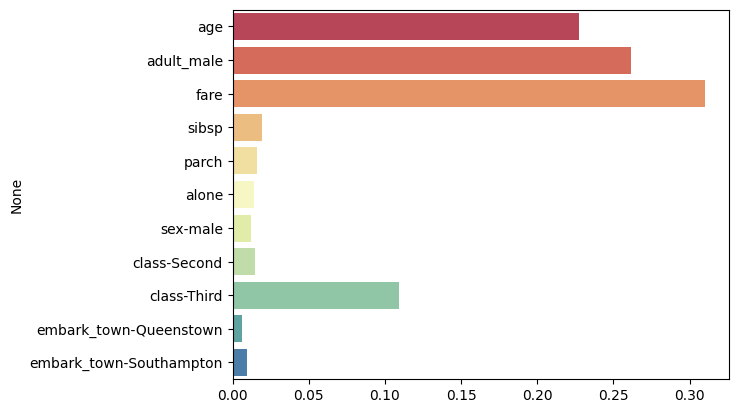

In [27]:
#%%    VEMOS QUÉ VARIABLES PESARON MÁS EN LAS DECISIONES DEL ÁRBOL
fi=arbol.feature_importances_
print(fi)
sns.barplot(y = X_train.columns, x = fi, palette='Spectral')

[0.26729161 0.13173066 0.27139952 0.04045657 0.03107815 0.01624842
 0.11844444 0.02286088 0.06211791 0.01303074 0.0253411 ]


<Axes: ylabel='None'>

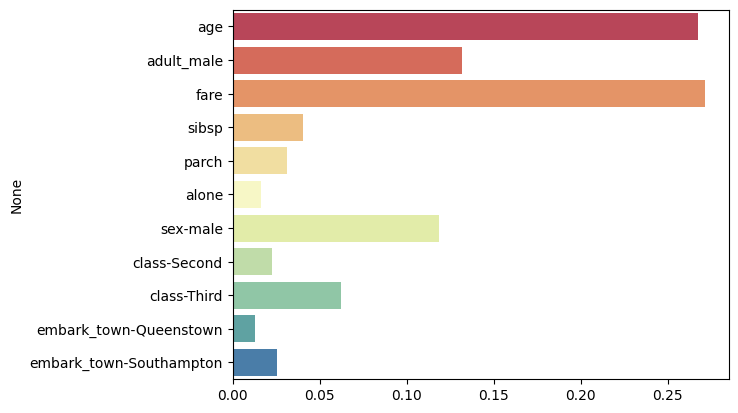

In [28]:
# idem para el bosque...
fiB=bosque.feature_importances_
print(fiB)
sns.barplot(y = X_train.columns, x = fiB, palette='Spectral')

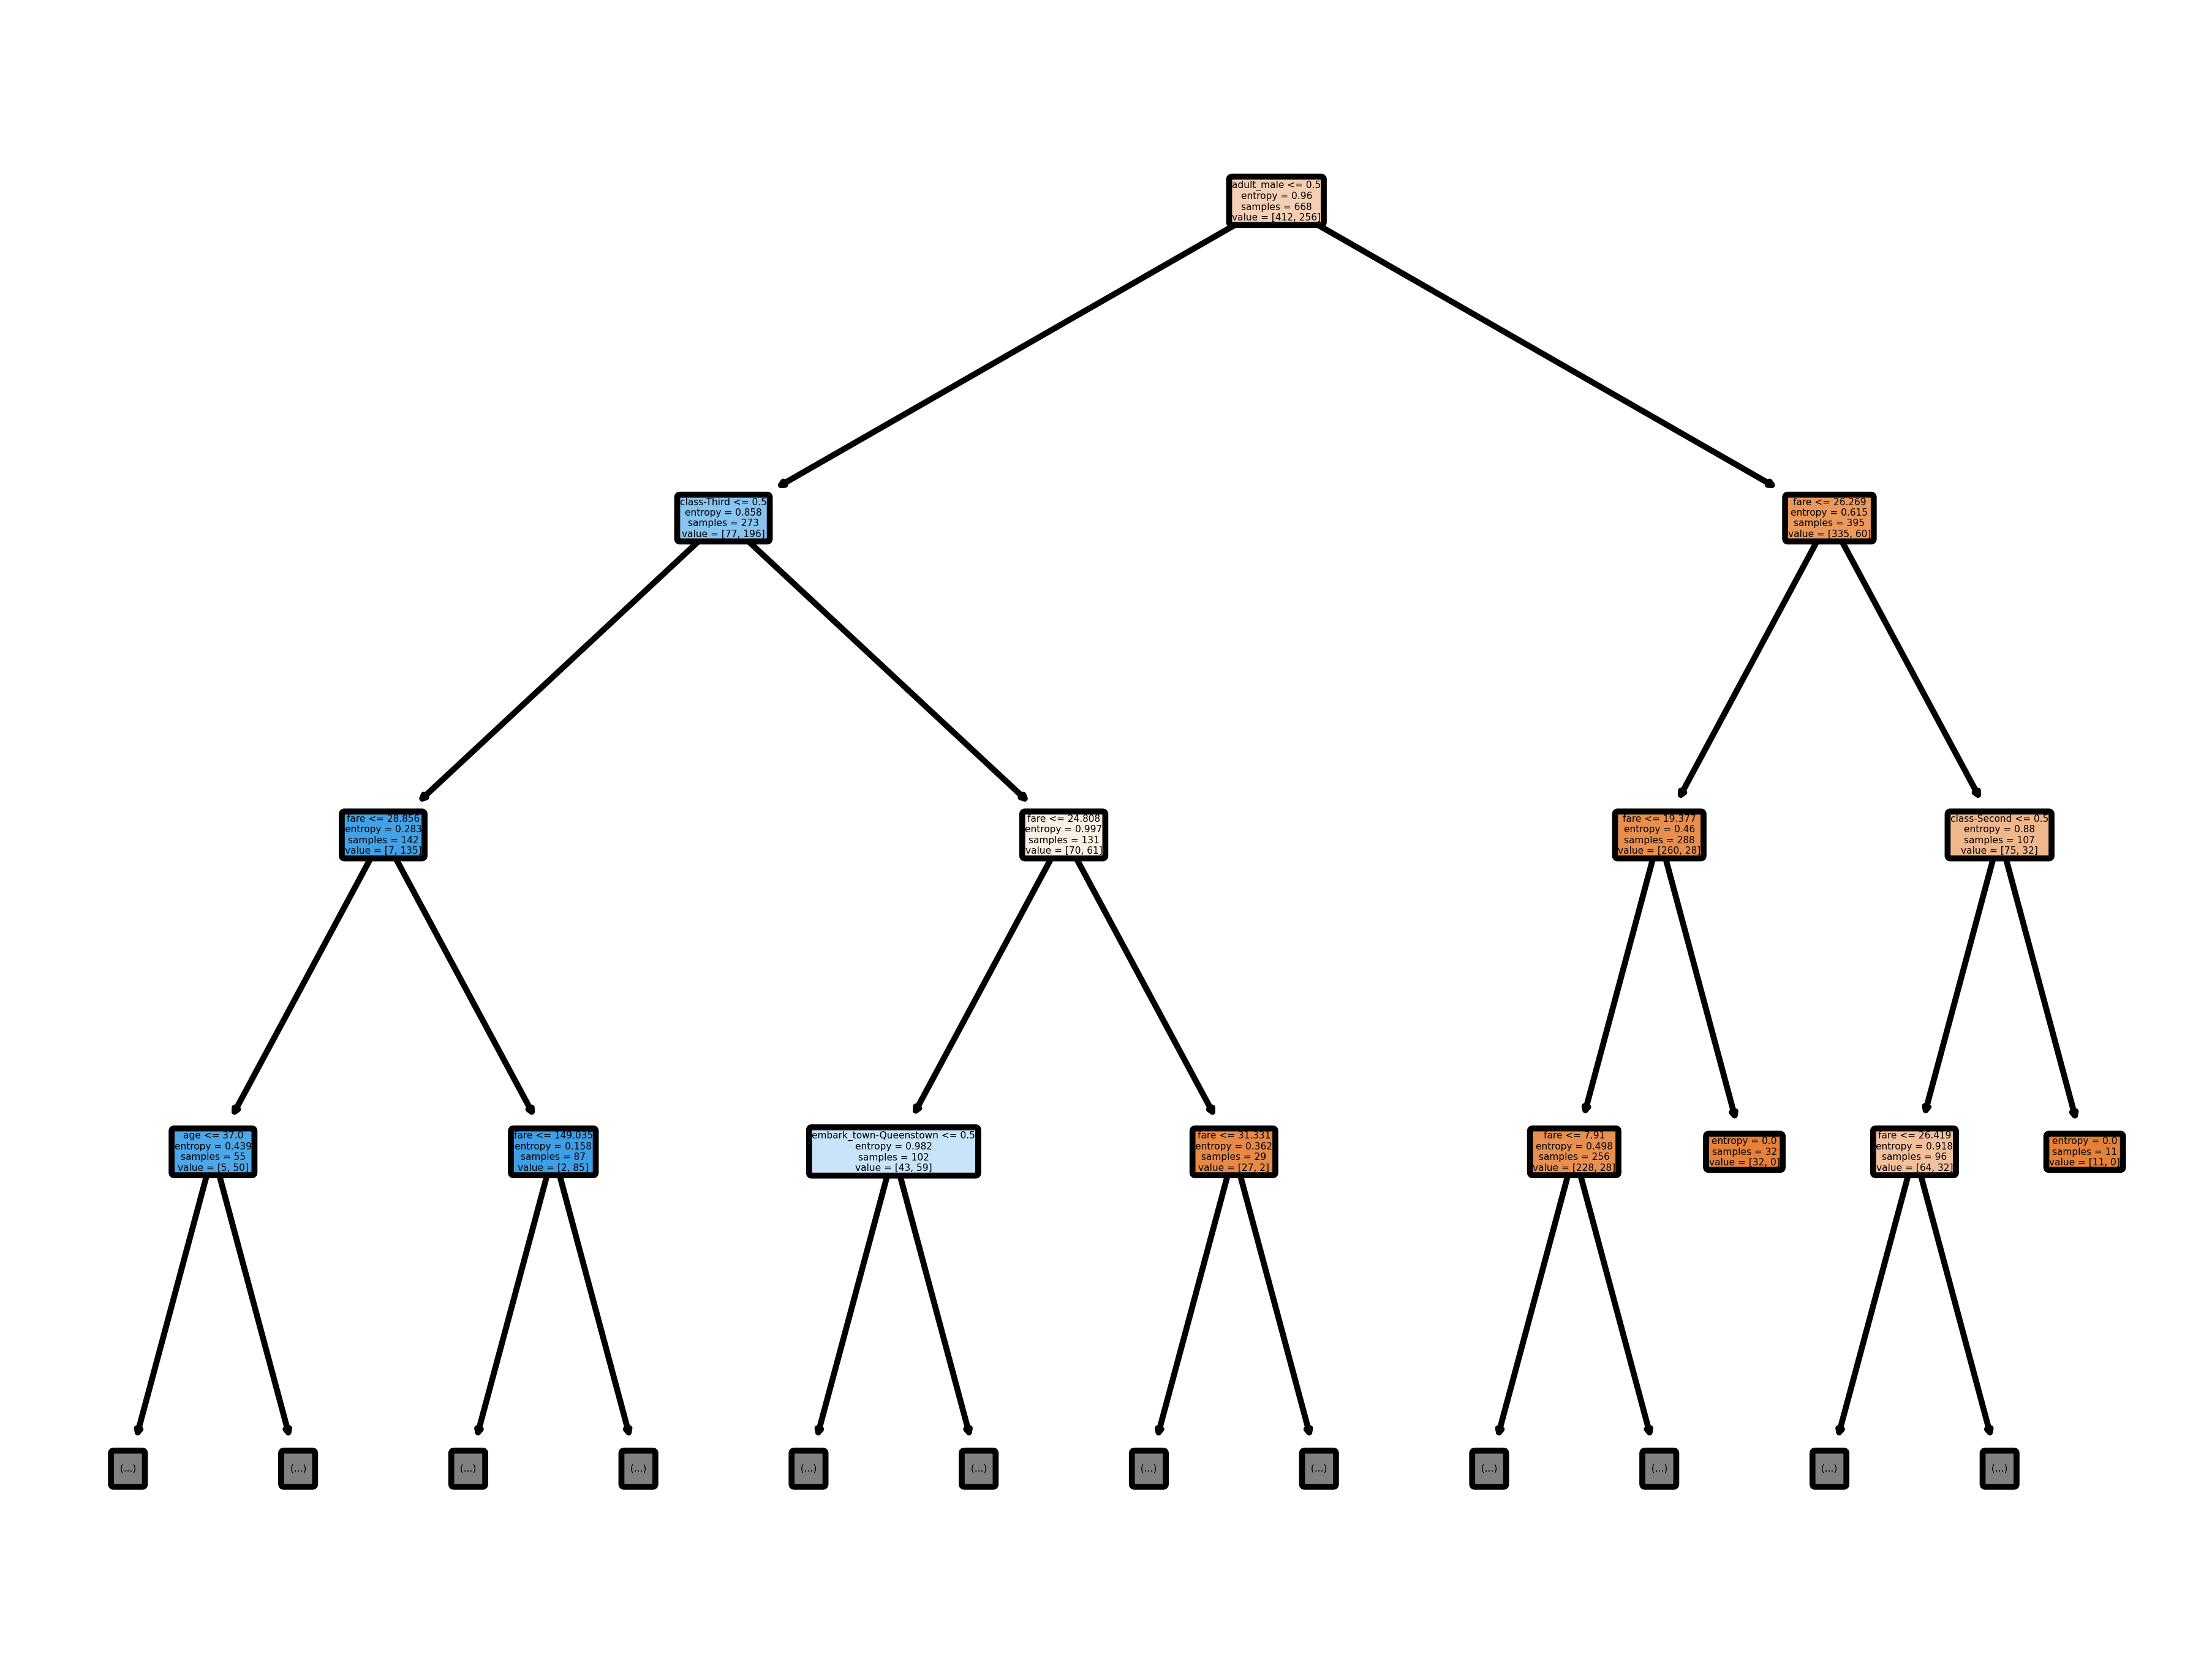

In [30]:
#%%   GRÁFICO DEL ÁRBOL
# plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None,
# label='all', filled=False, impurity=True, node_ids=False, proportion=False, rounded=False,
# precision=3, ax=None, fontsize=None)

list_features=list(X.columns)
plt.figure(dpi=700)
plot_tree(arbol, max_depth=3, filled=True, rounded=True, feature_names=list_features)
plt.show()
plt.close()

In [31]:
#%%    HACEMOS PREDICCIONES Y VEMOS SCORE
y_pred = arbol.predict(X_test)
print('Score train: ', arbol.score(X_train, y_train))
print('Score test:  ', arbol.score(X_test, y_test))

# Se ve claramente que el árbol está sobrejustando

Score train:  0.9925149700598802
Score test:   0.7937219730941704


In [32]:
#%%    HACEMOS PREDICCIONES Y VEMOS SCORE para el bosque
y_predB = bosque.predict(X_test)
print('Score train: ', bosque.score(X_train, y_train))
print('Score test:  ', bosque.score(X_test, y_test))
print('OOB Score: ', bosque.oob_score_)


Score train:  0.9925149700598802
Score test:   0.7982062780269058
OOB Score:  0.7964071856287425


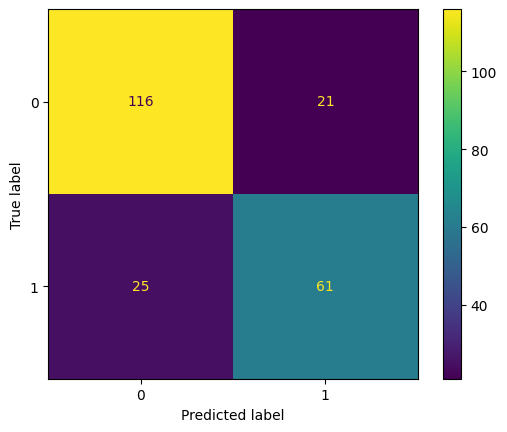

In [33]:
#%%    MATRIZ DE CONFUSION PARA VER MEJOR EL RENDIMIENTO DEL MODELO
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

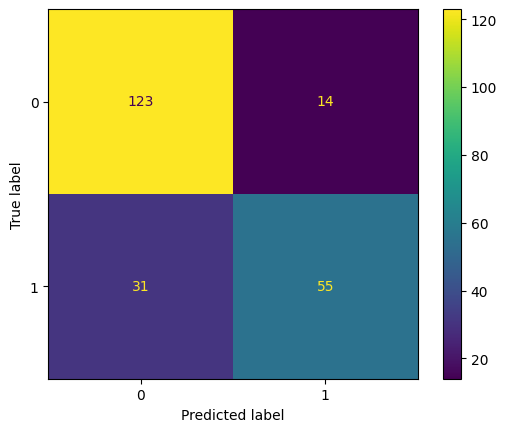

In [34]:
#%%    MATRIZ DE CONFUSION PARA VER MEJOR EL RENDIMIENTO DEL MODELO
cmB = confusion_matrix(y_test, y_predB)
ConfusionMatrixDisplay(cmB).plot()

In [37]:
#  Y LEO DI CAPRIO? QUÉ DICE EL MODELO QUE LE DEBIÓ SUCEDER?
'''
features = ['sex', 'age', 'sibsp', 'parch','fare', 'adult_male', 'alone', 'class-First',
 'class-Second', 'class-Third', 'embark_town-Cherbourg', 'embark_town-Queenstown',
 'embark_town-Southampton']
 '''
leo = {'age': [23], 'adult_male': [1],'fare':[7.],'sibsp':[0], 'parch':[0], 'alone':[0],'sex-male': [1], 'class-Second':[0], 'class-Third': [1],
       'embark_town-Queenstown':[0],'embark_town-Southampton':[1]}
leo1 = pd.DataFrame.from_dict(leo)
print('Leo sobrevivió, Árbol? ', arbol.predict(leo1))
print('Leo sobrevivió, Bosque? ', bosque.predict(leo1))
# Y Rose? qué fue de ella?
ros = {'age': [23], 'adult_male': [0],'fare':[70.],'sibsp':[0], 'parch':[1], 'alone':[0],'sex-male': [0], 'class-Second':[0], 'class-Third': [0],
       'embark_town-Queenstown':[0],'embark_town-Southampton':[1]}
rose = pd.DataFrame.from_dict(ros)
print(f'Rose sobrevivió, Árbol? {arbol.predict(rose)}')
print(f'Rose sobrevivió, Bosque? {bosque.predict(rose)}')
# Interesante, verdad?

Leo sobrevivió, Árbol?  [0]
Leo sobrevivió, Bosque?  [0]
Rose sobrevivió, Árbol? [1]
Rose sobrevivió, Bosque? [1]


In [51]:
# USO DE CCP ALPHA
alfa=np.arange(0, 0.5, 0.0005)
oob=[]
train=[]

for al in alfa:
  bosque2=RandomForestClassifier(random_state=16, criterion=criterio, oob_score=True, ccp_alpha=al)
  bosque2.fit(X_train, y_train)
  y_predB = bosque2.predict(X_test)
  oob.append(bosque2.oob_score_)
  train.append(bosque2.score(X_train, y_train))


maxalfa=max(oob)
print(maxalfa)
indmax=oob.index(maxalfa)
print(alfa[indmax])

0.8233532934131736

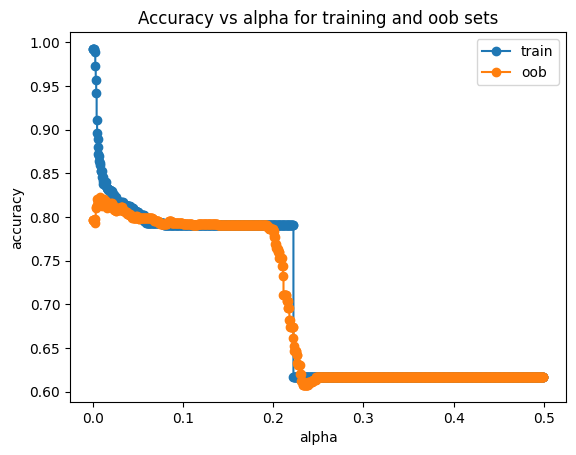

In [52]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and oob sets")
ax.plot(alfa, train, marker="o", label="train", drawstyle="steps-post")
ax.plot(alfa, oob, marker="o", label="oob", drawstyle="steps-post")
ax.legend()
plt.show()

In [55]:
print(len(alfa))
len(oob)

1000


1000

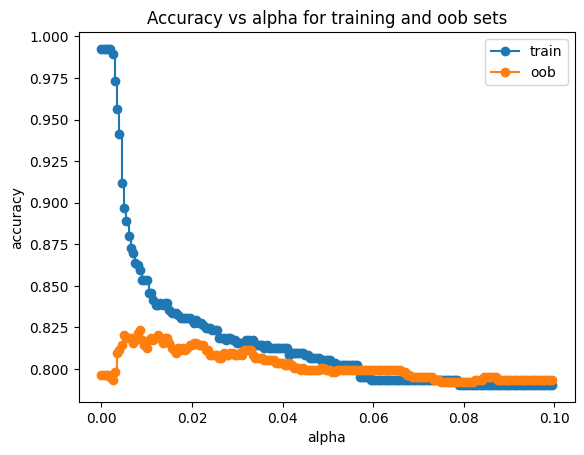

In [57]:
# mirar mejor entre 0 y 0.1
alfita=alfa[:200]
oobito=oob[:200]
trainito=train[:200]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and oob sets")
ax.plot(alfita, trainito, marker="o", label="train", drawstyle="steps-post")
ax.plot(alfita, oobito, marker="o", label="oob", drawstyle="steps-post")
ax.legend()
plt.show()

In [59]:
maxalfa=max(oob)
print(maxalfa)
indmax=oob.index(maxalfa)
print(alfa[indmax])
print(indmax)

0.8233532934131736
0.0085
17


In [60]:
best=RandomForestClassifier(random_state=16, criterion=criterio, oob_score=True, ccp_alpha=alfa[indmax])
best.fit(X_train, y_train)
y_best = best.predict(X_test)
print('Score train: ', best.score(X_train, y_train))
print('Score test:  ', best.score(X_test, y_test))
print('OOB Score: ', best.oob_score_)

Score train:  0.8592814371257484
Score test:   0.8251121076233184
OOB Score:  0.8233532934131736
